In [30]:
import ipyparallel as ipp
n = 4
rc = ipp.Cluster(engines="mpi", n=n).start_and_connect_sync()
view = rc[:]
rc.ids

Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/4 [00:00<?, ?engine/s]

[0, 1, 2, 3]

In [31]:
%%px --block
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpi4py import MPI
import copy
import sys
import time
sys.path.append('../../../Decentralized-FL-Framework')
from communication import DecentralizedNoModelSGD
from misc import Recorder
from comm_weights import flatten_weights, unflatten_weights
from network import Graph


np.random.seed(482)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

mpi = MPI.COMM_WORLD
bcast = mpi.bcast
barrier = mpi.barrier
rank = mpi.rank
size = mpi.size
print("MPI rank: %i/%i" % (mpi.rank, mpi.size))

[stdout:0] MPI rank: 0/4


[stdout:2] MPI rank: 2/4


[stdout:3] MPI rank: 3/4


[stdout:1] MPI rank: 1/4


## Helper Functions

In [32]:
%%px --block
# Implement Custom Loss Function
@tf.function
def consensus_loss(y_true, y_pred, z, l2):
    
    # local error
    local_loss = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    # consensus error
    consensus_loss = l2*tf.keras.losses.CategoricalCrossentropy()(z, y_pred)
        
    return local_loss + consensus_loss

In [33]:
 %%px --block
# Play around with this more
def set_learning_rate(optimizer, epoch):
    if epoch >= 1:
        optimizer.lr = optimizer.lr * tf.math.exp(-0.1)

In [34]:
%%px --block
def average_models(model, local_update, layer_shapes, layer_sizes):
    model_weights = model.get_weights()
    # flatten tensor weights
    coordinate_weights = flatten_weights(model_weights)
    local_weights = flatten_weights(local_update)
    next_weights = unflatten_weights(np.average([coordinate_weights, local_weights], axis=0),
                                           layer_shapes, layer_sizes)
    # update model weights to average
    model.set_weights(next_weights)

In [35]:
%%px --block
def get_model_architecture(model):
    # find shape and total elements for each layer of the resnet model
    model_weights = model.get_weights()
    layer_shapes = []
    layer_sizes = []
    for i in range(len(model_weights)):
        layer_shapes.append(model_weights[i].shape)
        layer_sizes.append(model_weights[i].size)
    return layer_shapes, layer_sizes

In [36]:
%%px --block

def data_pre_process(rank, size, train_pct, train_bs, test_bs, coordination_size, coord_bs):

    # read in CSV data
    raw_df_data = pd.read_csv("Data/Darknet.CSV", parse_dates=["Timestamp"], on_bad_lines='skip')

    # make timestamp numeric (just time of day)
    timestamp = raw_df_data["Timestamp"]
    raw_df_data["Timestamp"] = timestamp.dt.hour + timestamp.dt.minute/60 + timestamp.dt.second/3600

    # remove NaN rows and Inf
    raw_df = raw_df_data.replace([np.inf, -np.inf], np.nan)
    raw_df.dropna(inplace=True)

    # clean up the sub-labels (incorrectly labeled)
    raw_df.loc[raw_df['Label.1']=='AUDIO-STREAMING', 'Label.1'] = 'Audio-Streaming'
    raw_df.loc[raw_df['Label.1']=='AUDIO-STREAMING', 'Label.1'] = 'Audio-Streaming'
    raw_df.loc[raw_df['Label.1']=='Video-streaming', 'Label.1'] = 'Video-Streaming'
    raw_df.rename(columns = {"Label.1" : "Subtype"}, inplace = True)

    # add one-hot encoding of the sub-labels
    onehot = pd.get_dummies(raw_df['Subtype'])
    raw_df = pd.concat([raw_df, onehot], axis=1, join='inner')

    # drop IP columns and 0 columns
    ip_cols = ['Flow ID', 'Src IP', 'Dst IP', 'Active Mean', 'Active Std', 'Active Max', 
               'Active Min', 'Subflow Bwd Packets', 'Fwd Bytes/Bulk Avg', 'Fwd Packet/Bulk Avg', 
               'Fwd Bulk Rate Avg', 'Bwd Bytes/Bulk Avg', 'URG Flag Count', 'CWE Flag Count', 
               'ECE Flag Count', 'Bwd PSH Flags', 'Fwd URG Flags','Bwd URG Flags']
    raw_df.drop(ip_cols, axis=1, inplace=True)

    # label dataframe
    traffic_categories = raw_df['Label'].unique()
    tc = dict(zip(traffic_categories, range(len(traffic_categories))))
    class_attack = raw_df.Label.map(lambda a: tc[a])
    raw_df['Label'] = class_attack

    # shuffle dataset
    raw_df = raw_df.sample(frac=1)

    # extract features
    non_normalized_df = raw_df.drop(['Label', 'Subtype'], axis=1)

    # extract labels
    labels = raw_df['Label']

    # normalize the feature dataframe
    normalized_df = non_normalized_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

    # create coordination set
    coord_x = tf.convert_to_tensor(normalized_df.iloc[:coordination_size,:])
    coord_y = tf.convert_to_tensor(labels[:coordination_size])
    coordination_set = tf.data.Dataset.from_tensor_slices((coord_x,coord_y)).batch(coord_bs)

    # get data info
    num_inputs = len(normalized_df.columns.to_list())
    num_outputs = len(traffic_categories)
    
    # Split training data amongst workers
    worker_data = np.array_split(normalized_df.iloc[coordination_size:,:], size)[rank]
    worker_label = np.array_split(labels[coordination_size:], size)[rank]
    
    # create train/test split
    num_data = len(worker_label)
    num_train =  int(num_data * train_pct)
    # train
    train_x = tf.convert_to_tensor(worker_data.iloc[:num_train,:])
    train_y = tf.convert_to_tensor(worker_label[:num_train])
    train_set = tf.data.Dataset.from_tensor_slices((train_x,train_y)).batch(train_bs)
    # test
    test_x = tf.convert_to_tensor(worker_data.iloc[num_train:,:])
    test_y = tf.convert_to_tensor(worker_label[num_train:])
    test_set = tf.data.Dataset.from_tensor_slices((test_x,test_y)).batch(test_bs)
    
    # full training set
    # full_train_data = tf.convert_to_tensor(normalized_df)
    # full_train_label = tf.convert_to_tensor(labels)
    
    # non-iid Dataset
    # create train/test split
    nid_num_data = len(labels[coordination_size:])
    nid_num_train = int(nid_num_data * train_pct)
    normalized_df['Label'] = labels
    
    # Skew Non-IID
    nid_test_df = normalized_df[(coordination_size+nid_num_train):]
    test_labels = nid_test_df['Label']
    skew_df_sort = normalized_df[coordination_size:(coordination_size+nid_num_train)].sort_values(by=['Label'])
    nid_labels = skew_df_sort['Label']
    skew_df_sort = skew_df_sort.drop(['Label'], axis=1)
    nid_test_df = nid_test_df.drop(['Label'], axis=1)
    nid_worker_data = np.array_split(skew_df_sort, size)[rank]
    nid_worker_label = np.array_split(nid_labels, size)[rank]
    
    # Non-IID train
    nid_train_x = tf.convert_to_tensor(nid_worker_data)
    nid_train_y = tf.convert_to_tensor(nid_worker_label)
    nid_train_set = tf.data.Dataset.from_tensor_slices((nid_train_x, nid_train_y)).batch(train_bs)
    # Non-IID test
    nid_test_x = tf.convert_to_tensor(nid_test_df)
    nid_test_y = tf.convert_to_tensor(test_labels)
    
    return train_set, test_set, coordination_set, nid_train_set, nid_test_x, nid_test_y, num_inputs, num_outputs # full_train_data, full_train_label

In [37]:
%%px --block
def train(model, lossF, optimizer, train_dataset, epochs, recorder):

    acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy()

    for epoch in range(epochs):

        # Adjust learning rate
        set_learning_rate(optimizer, epoch)

        record_time = 0
        e_init_time = time.time()

        # Local Training
        for batch_idx, (data, target) in enumerate(train_dataset):

            # Minibatch Update
            with tf.GradientTape() as tape:
                y_p = model(data, training=True)
                loss_val = lossF(y_true=target, y_pred=y_p)
            grads = tape.gradient(loss_val, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            r_time = time.time()
            acc_metric.update_state(target, y_p)
            loss_metric.update_state(target, y_p)
            record_time += (time.time() - r_time)

        e_time = (time.time() - e_init_time) - record_time
        e_loss = loss_metric.result()
        e_acc = acc_metric.result()
        print('(Rank %d) Epoch %d: Time is %0.4f, Training Accuracy is %0.4f, Loss is %0.4f' % (rank, epoch+1, e_time, e_acc, e_loss))
        recorder.add_to_file(e_time, e_time, np.NaN, e_loss, e_acc)
        recorder.save_to_file()
        loss_metric.reset_states()
        acc_metric.reset_states()

In [38]:
%%px --block
def middle_train(model, communicator, rank, size, lossF, optimizer, train_dataset, coordination_dataset, epochs, 
          coord_batch_size, batches, num_outputs, layer_shapes, layer_sizes, l2, recorder):

    acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy()

    for epoch in range(epochs):

        # Adjust learning rate
        set_learning_rate(optimizer, epoch)

        record_time = 0
        comm_time = 0
        non_comp = 0
        e_init_time = time.time()

        # Local Training
        for batch_idx, (data, target) in enumerate(train_dataset):

            # Forward Pass of Coordination Set (get z)
            send_predicted = np.zeros((num_outputs*coord_batch_size, batches), dtype=np.float32)
            for c_batch_idx, (c_data, c_target) in enumerate(coordination_dataset):
                pred = model(c_data, training=True)
                send_predicted[:, c_batch_idx] = pred.numpy().flatten()

            t1 = time.time()
            # Communication Process Here
            recv_avg_pred, c_time = communicator.average(send_predicted)
            comm_time += c_time

            # save pre-batch model
            start_model = copy.deepcopy(model.get_weights())
            non_comp += (time.time() - t1)


            # Minibatch Update
            with tf.GradientTape() as tape:
                y_p = model(data, training=True)
                loss_val = lossF(y_true=target, y_pred=y_p)
            grads = tape.gradient(loss_val, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            t1 = time.time()
            acc_metric.update_state(target, y_p)
            loss_metric.update_state(target, y_p)
            record_time = (time.time() - t1)

            # save model after batch
            local_model = copy.deepcopy(model.get_weights())

            # reset model weights
            model.set_weights(start_model)
            non_comp += (time.time() - t1)

            # Consensus Training
            for c_batch_idx, (c_data, c_target) in enumerate(coordination_dataset):
                with tf.GradientTape() as tape:
                    c_yp = model(c_data, training=True)
                    loss_val = consensus_loss(y_true=c_target, y_pred=c_yp,
                                               z=recv_avg_pred[:, c_batch_idx].reshape(coord_batch_size, num_outputs),
                                               l2=l2)
                grads = tape.gradient(loss_val, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # update model weights
            average_models(model, local_model, layer_shapes, layer_sizes)



        e_time = (time.time() - e_init_time) - record_time
        comp_time = e_time - non_comp - comm_time
        e_loss = loss_metric.result()
        e_acc = acc_metric.result()
        print('(Rank %d) Epoch %d: Time is %0.4f, Training Accuracy is %0.4f, Loss is %0.4f' % (rank, epoch+1, e_time, e_acc, e_loss))
        recorder.add_to_file(e_time, comp_time, comm_time, e_loss, e_acc)
        recorder.save_to_file()
        loss_metric.reset_states()
        acc_metric.reset_states()

## Run Experiments

In [39]:
%%px --block
train_pct = 0.8
train_bs = 128
test_bs = 128
coordination_size = 2 ** 7
coord_bs = coordination_size
coord_num_batches = int(np.ceil(coordination_size/coord_bs))

# preprocess and split data amongst workers
train_set, test_set, coord_set, nid_train_set, nid_test_x, nid_test_y, num_inputs, num_outputs = data_pre_process(rank, size, train_pct, train_bs, test_bs, coordination_size, coord_bs)

# add in coordination set for regular training
reg_train_set = nid_train_set.concatenate(coord_set)



%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

In [40]:
%%px --block

# initialize graph
graph_type = 'ring'
G = Graph(rank, size, mpi, graph_type, weight_type='uniform-symmetric', num_c=None)

# initialize communicator
communicator = DecentralizedNoModelSGD(rank, size, mpi, G)

In [41]:
%%px --block

# normal train model
if rank == 0 or rank == 1:
    multi_model = tf.keras.Sequential()
    multi_model.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(num_inputs,)))
    multi_model.add(tf.keras.layers.Dense(256, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(128, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(64, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(10, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(num_outputs, activation='softmax'))
else:
    multi_model = tf.keras.Sequential()
    multi_model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(num_inputs,)))
    multi_model.add(tf.keras.layers.Dense(128, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(256, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(128, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(64, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(10, activation='relu'))
    multi_model.add(tf.keras.layers.Dense(num_outputs, activation='softmax'))

# Initialize Local Loss Function
lossF = tf.keras.losses.SparseCategoricalCrossentropy()

# model architecture
layer_shapes, layer_sizes = get_model_architecture(multi_model)

# l2 penalty
l2 = 1

# epochs
epochs = 10

# Initialize Optimizer
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Create MIDDLE model (same architecture and weights) for comparison
middle_model = tf.keras.models.clone_model(multi_model)

# Output Path
outputPath = 'Results'
saveFolder_reg = outputPath + '/' + 'RegularTrain' + '-' + str(size) + 'Worker-' + str(epochs) + \
                              'Epochs-' + 'NoPenalty-' + str(coordination_size) + 'Csize-' + str(graph_type)
saveFolder_middle = outputPath + '/' + 'MIDDLE' + '-' + str(size) + 'Worker-' + str(epochs) + \
                              'Epochs-' + str(l2) + 'Penalty-' + str(coordination_size) + 'Csize-' + str(graph_type)

In [42]:
%%px --block
# Regular training results
# train(multi_model, lossF, optimizer, train_set, epochs)
# non-iid train
initial_lr = optimizer.lr
recorder_reg = Recorder('RegularTrain', size, rank, graph_type, epochs, 'No', coordination_size, outputPath)
train(multi_model, lossF, optimizer, reg_train_set, epochs, recorder_reg)

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[stdout:0] (Rank 0) Epoch 1: Time is 3.1184, Training Accuracy is 0.9939, Loss is 1.9689
(Rank 0) Epoch 2: Time is 3.2134, Training Accuracy is 0.9984, Loss is 0.2201
(Rank 0) Epoch 3: Time is 2.9348, Training Accuracy is 0.9979, Loss is 0.2400
(Rank 0) Epoch 4: Time is 3.0103, Training Accuracy is 0.9984, Loss is 0.0452
(Rank 0) Epoch 5: Time is 3.1744, Training Accuracy is 0.9984, Loss is 0.0753
(Rank 0) Epoch 6: Time is 2.9300, Training Accuracy is 0.9969, Loss is 0.0298
(Rank 0) Epoch 7: Time is 3.1262, Training Accuracy is 0.9984, Loss is 0.0561
(Rank 0) Epoch 8: Time is 3.0192, Training Accuracy is 0.9984, Loss is 0.0303
(Rank 0) Epoch 9: Time is 3.0015, Training Accuracy is 0.9984, Loss is 0.0323
(Rank 0) Epoch 10: Time is 3.0464, Training Accuracy is 0.9984, Loss is 0.0233


[stdout:1] (Rank 1) Epoch 1: Time is 3.1203, Training Accuracy is 0.9970, Loss is 2.0761
(Rank 1) Epoch 2: Time is 3.2282, Training Accuracy is 0.9984, Loss is 0.2746
(Rank 1) Epoch 3: Time is 2.9531, Training Accuracy is 0.9984, Loss is 0.0515
(Rank 1) Epoch 4: Time is 3.0930, Training Accuracy is 0.9984, Loss is 0.0304
(Rank 1) Epoch 5: Time is 3.1609, Training Accuracy is 0.9984, Loss is 0.0332
(Rank 1) Epoch 6: Time is 2.9526, Training Accuracy is 0.9984, Loss is 0.0178
(Rank 1) Epoch 7: Time is 3.1444, Training Accuracy is 0.9984, Loss is 0.0118
(Rank 1) Epoch 8: Time is 3.0319, Training Accuracy is 0.9984, Loss is 0.0160
(Rank 1) Epoch 9: Time is 3.0499, Training Accuracy is 0.9984, Loss is 0.0120
(Rank 1) Epoch 10: Time is 3.0446, Training Accuracy is 0.9984, Loss is 0.0113


[stdout:2] (Rank 2) Epoch 1: Time is 3.4501, Training Accuracy is 0.9668, Loss is 25.7018
(Rank 2) Epoch 2: Time is 3.4831, Training Accuracy is 0.6504, Loss is 0.8009
(Rank 2) Epoch 3: Time is 3.2007, Training Accuracy is 0.6234, Loss is 0.7329
(Rank 2) Epoch 4: Time is 3.4863, Training Accuracy is 0.5918, Loss is 0.7290
(Rank 2) Epoch 5: Time is 3.3445, Training Accuracy is 0.5738, Loss is 0.7266
(Rank 2) Epoch 6: Time is 3.2282, Training Accuracy is 0.5557, Loss is 0.7232
(Rank 2) Epoch 7: Time is 3.3797, Training Accuracy is 0.5422, Loss is 0.7190
(Rank 2) Epoch 8: Time is 3.2348, Training Accuracy is 0.5332, Loss is 0.7147
(Rank 2) Epoch 9: Time is 3.2415, Training Accuracy is 0.5332, Loss is 0.7104
(Rank 2) Epoch 10: Time is 3.1066, Training Accuracy is 0.5287, Loss is 0.7063


[stdout:3] (Rank 3) Epoch 1: Time is 3.4679, Training Accuracy is 0.8901, Loss is 46.5854
(Rank 3) Epoch 2: Time is 3.4884, Training Accuracy is 0.8720, Loss is 2.6434
(Rank 3) Epoch 3: Time is 3.2610, Training Accuracy is 0.7813, Loss is 1.0579
(Rank 3) Epoch 4: Time is 3.5099, Training Accuracy is 0.6446, Loss is 0.8803
(Rank 3) Epoch 5: Time is 3.3543, Training Accuracy is 0.6446, Loss is 0.8568
(Rank 3) Epoch 6: Time is 3.2877, Training Accuracy is 0.6446, Loss is 0.8452
(Rank 3) Epoch 7: Time is 3.3877, Training Accuracy is 0.6446, Loss is 0.8381
(Rank 3) Epoch 8: Time is 3.2568, Training Accuracy is 0.6446, Loss is 0.8328
(Rank 3) Epoch 9: Time is 3.2753, Training Accuracy is 0.6446, Loss is 0.8286
(Rank 3) Epoch 10: Time is 2.9652, Training Accuracy is 0.6446, Loss is 0.8250


In [43]:
%%px --block
recorder_middle = Recorder('MIDDLE', size, rank, graph_type, epochs, l2, coordination_size, outputPath)
middle_train(middle_model, communicator, rank, size, lossF, optimizer, nid_train_set,
      coord_set, epochs, coord_bs, coord_num_batches, num_outputs, layer_shapes, layer_sizes, l2, recorder_middle)

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[stdout:1] (Rank 1) Epoch 1: Time is 11.4633, Training Accuracy is 0.9900, Loss is 0.0485
(Rank 1) Epoch 2: Time is 11.1284, Training Accuracy is 0.9971, Loss is 0.0125
(Rank 1) Epoch 3: Time is 11.3220, Training Accuracy is 0.9982, Loss is 0.0077
(Rank 1) Epoch 4: Time is 11.1121, Training Accuracy is 0.9986, Loss is 0.0054
(Rank 1) Epoch 5: Time is 10.8881, Training Accuracy is 0.9996, Loss is 0.0017
(Rank 1) Epoch 6: Time is 10.9909, Training Accuracy is 0.9998, Loss is 0.0011
(Rank 1) Epoch 7: Time is 11.0593, Training Accuracy is 0.9997, Loss is 0.0017
(Rank 1) Epoch 8: Time is 10.6265, Training Accuracy is 0.9999, Loss is 0.0008
(Rank 1) Epoch 9: Time is 10.5709, Training Accuracy is 0.9999, Loss is 0.0007
(Rank 1) Epoch 10: Time is 11.1277, Training Accuracy is 0.9999, Loss is 0.0005


[stdout:0] (Rank 0) Epoch 1: Time is 11.4628, Training Accuracy is 0.9805, Loss is 0.0779
(Rank 0) Epoch 2: Time is 11.1284, Training Accuracy is 0.9963, Loss is 0.0155
(Rank 0) Epoch 3: Time is 11.3294, Training Accuracy is 0.9990, Loss is 0.0051
(Rank 0) Epoch 4: Time is 11.1035, Training Accuracy is 0.9995, Loss is 0.0032
(Rank 0) Epoch 5: Time is 10.8876, Training Accuracy is 0.9995, Loss is 0.0023
(Rank 0) Epoch 6: Time is 10.9907, Training Accuracy is 0.9996, Loss is 0.0020
(Rank 0) Epoch 7: Time is 11.0592, Training Accuracy is 0.9998, Loss is 0.0014
(Rank 0) Epoch 8: Time is 10.6264, Training Accuracy is 0.9998, Loss is 0.0011
(Rank 0) Epoch 9: Time is 10.5700, Training Accuracy is 0.9998, Loss is 0.0008
(Rank 0) Epoch 10: Time is 11.1266, Training Accuracy is 0.9999, Loss is 0.0007


[stdout:2] (Rank 2) Epoch 1: Time is 11.4687, Training Accuracy is 0.9727, Loss is 0.1926
(Rank 2) Epoch 2: Time is 11.1254, Training Accuracy is 0.9631, Loss is 0.1010
(Rank 2) Epoch 3: Time is 11.3225, Training Accuracy is 0.9830, Loss is 0.0578
(Rank 2) Epoch 4: Time is 11.1124, Training Accuracy is 0.9873, Loss is 0.0462
(Rank 2) Epoch 5: Time is 10.8873, Training Accuracy is 0.9902, Loss is 0.0355
(Rank 2) Epoch 6: Time is 10.9910, Training Accuracy is 0.9914, Loss is 0.0323
(Rank 2) Epoch 7: Time is 11.0579, Training Accuracy is 0.9913, Loss is 0.0304
(Rank 2) Epoch 8: Time is 10.6267, Training Accuracy is 0.9918, Loss is 0.0278
(Rank 2) Epoch 9: Time is 10.5713, Training Accuracy is 0.9923, Loss is 0.0271
(Rank 2) Epoch 10: Time is 11.1255, Training Accuracy is 0.9928, Loss is 0.0259


[stdout:3] (Rank 3) Epoch 1: Time is 11.4685, Training Accuracy is 0.9156, Loss is 0.4042
(Rank 3) Epoch 2: Time is 11.1261, Training Accuracy is 0.9260, Loss is 0.2255
(Rank 3) Epoch 3: Time is 11.3215, Training Accuracy is 0.9387, Loss is 0.1705
(Rank 3) Epoch 4: Time is 11.1140, Training Accuracy is 0.9446, Loss is 0.1433
(Rank 3) Epoch 5: Time is 10.8871, Training Accuracy is 0.9501, Loss is 0.1264
(Rank 3) Epoch 6: Time is 10.9954, Training Accuracy is 0.9662, Loss is 0.1084
(Rank 3) Epoch 7: Time is 11.0590, Training Accuracy is 0.9710, Loss is 0.1070
(Rank 3) Epoch 8: Time is 10.6206, Training Accuracy is 0.9737, Loss is 0.0933
(Rank 3) Epoch 9: Time is 10.5709, Training Accuracy is 0.9747, Loss is 0.0924
(Rank 3) Epoch 10: Time is 11.1299, Training Accuracy is 0.9789, Loss is 0.0816


In [44]:
%%px --block
#reg_predictions = multi_model.predict(full_train_x)
#middle_predictions = middle_model.predict(full_train_x)
reg_predictions = multi_model.predict(nid_test_x)
middle_predictions = middle_model.predict(nid_test_x)

[stdout:0] 884/884 [==============================] - 1s 2ms/step
884/884 [==============================] - 1s 2ms/step


[stdout:3] 884/884 [==============================] - 2s 2ms/step
884/884 [==============================] - 1s 2ms/step


[stdout:1] 884/884 [==============================] - 1s 2ms/step
884/884 [==============================] - 1s 2ms/step


[stdout:2] 884/884 [==============================] - 2s 2ms/step
884/884 [==============================] - 1s 2ms/step


%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

In [45]:
%%px --block
    # regular training
    pred = tf.math.argmax(reg_predictions, axis=1)
    # train_confusion_mtx = tf.math.confusion_matrix(full_train_y, pred)
    train_confusion_mtx = tf.math.confusion_matrix(nid_test_y, pred)
    # normalize confusion matrix
    train_confusion_mtx = train_confusion_mtx / tf.reduce_sum(train_confusion_mtx, 0).numpy()
    train_confusion_mtx = tf.where(tf.math.is_nan(train_confusion_mtx), tf.zeros_like(train_confusion_mtx),
                                   train_confusion_mtx)
    # middle training
    pred_middle = tf.math.argmax(middle_predictions, axis=1)
    # middle_train_confusion_mtx = tf.math.confusion_matrix(full_train_y, pred_middle)
    middle_train_confusion_mtx = tf.math.confusion_matrix(nid_test_y, pred_middle)
    # normalize confusion matrix
    middle_train_confusion_mtx = middle_train_confusion_mtx / tf.reduce_sum(middle_train_confusion_mtx, 0).numpy()
    middle_train_confusion_mtx = tf.where(tf.math.is_nan(middle_train_confusion_mtx),
                                          tf.zeros_like(middle_train_confusion_mtx), middle_train_confusion_mtx)

[output:1]

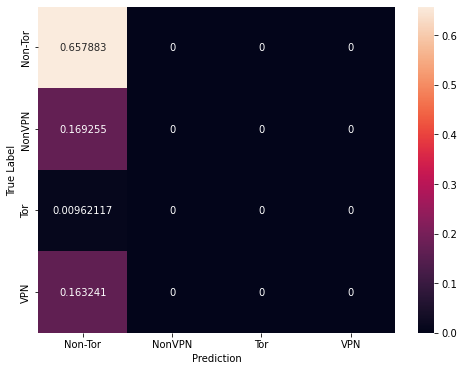

[output:0]

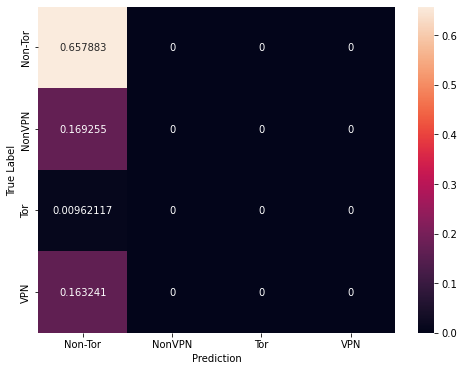

[output:2]

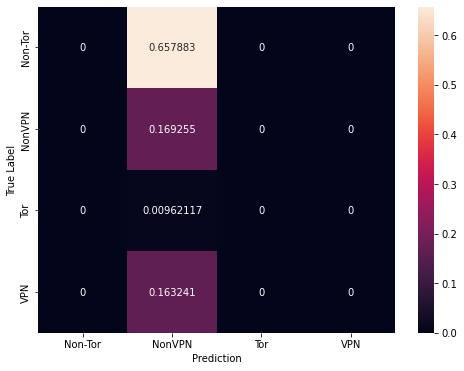

[output:3]

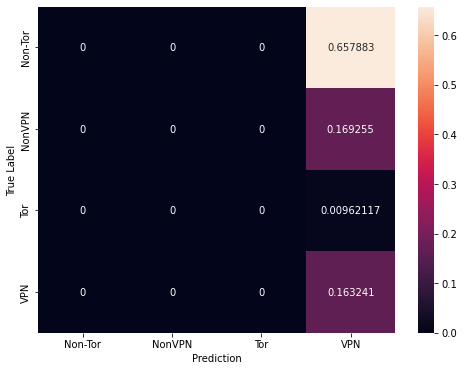

In [46]:
%%px --block
    # Regular Training Results
    attack_labels = ['Non-Tor', 'NonVPN', 'Tor', 'VPN']
    plt.figure(figsize=(8, 6))
    sns.heatmap(train_confusion_mtx,
                xticklabels=attack_labels,
                yticklabels=attack_labels,
                annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('True Label')
    # plt.title('Regular Training Confusion Matrix for Worker %d on CIC-Darknet2020 Data' % (rank+1))
    plt.savefig(saveFolder_reg + '/Regular-r' + str(rank) + '.pdf', format="pdf")
    plt.show()

[output:2]

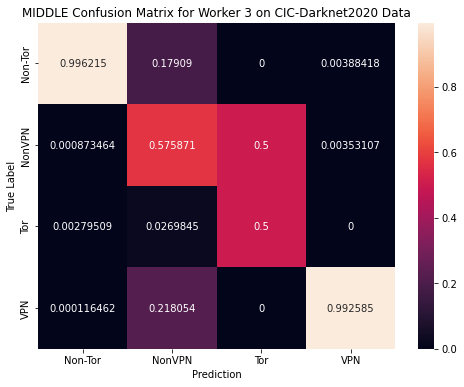

[output:1]

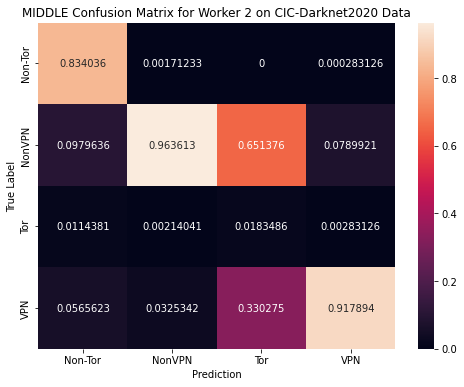

[output:0]

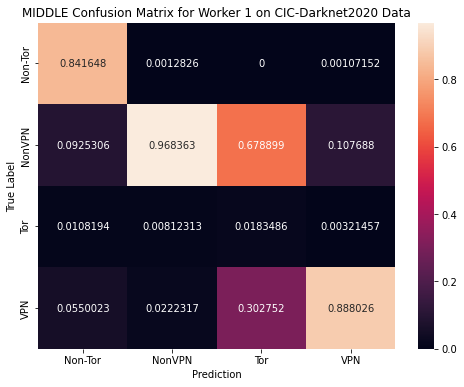

[output:3]

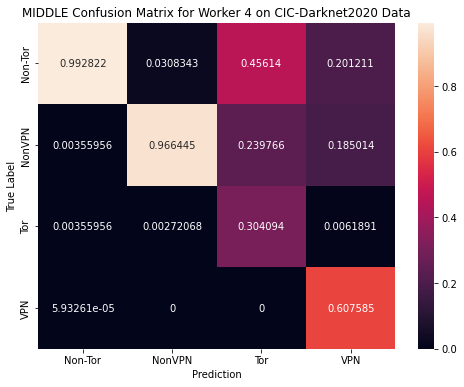

In [47]:
%%px --block
    # MIDDLE Training Results
    attack_labels = ['Non-Tor', 'NonVPN', 'Tor', 'VPN']
    plt.figure(figsize=(8, 6))
    sns.heatmap(middle_train_confusion_mtx,
                xticklabels=attack_labels,
                yticklabels=attack_labels,
                annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('True Label')
    plt.title('MIDDLE Confusion Matrix for Worker %d on CIC-Darknet2020 Data' % (rank+1))
    plt.savefig(saveFolder_middle + '/Regular-r' + str(rank) + '.pdf', format="pdf")
    plt.show()